In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pickle

import numpy as np
import pandas as pd
from sklearn.utils import shuffle

import bandmat as bm
import numpy as np
from scipy.linalg import solve_banded
import matplotlib.pyplot as plt
from scipy.constants import g

In [3]:
def smooth(a, Phat, N, lambda_1, lambda_2):
    """
    a: (N,) number of measurements at timestep
    Phat: (N, 3) sum of measurements at timestep
    N: num time steps
    lambda_1, lambda_2: regularization parameters
    
    returns:
        - P: (N, 3)
    """
    A = bm.diag(1.*a)
    
    D_2_bm_T = bm.BandMat(
        1, 1,
        np.hstack([np.zeros((3, 1)), np.repeat([[1.], [-2.], [1.]], N-2, axis=1), np.zeros((3, 1))])
    )
    
    D_3_bm_T = bm.BandMat(
        2, 2,
        np.hstack([np.zeros((5, 2)), np.repeat([[-1.], [2.], [0.], [-2.], [1.]], N-4, axis=1), np.zeros((5, 2))])
    )
        
    ab = bm.dot_mm(A, A) + lambda_1/N * bm.dot_mm(D_2_bm_T, D_2_bm_T.T) + lambda_2/N * bm.dot_mm(D_3_bm_T, D_3_bm_T.T)
    l_and_u = (ab.l, ab.u)
    b = np.hstack([
            np.expand_dims(bm.dot_mv(A, Phat[:, 0]), -1),
            np.expand_dims(bm.dot_mv(A, Phat[:, 1]), -1),
            np.expand_dims(bm.dot_mv(A, Phat[:, 2]), -1)
    ])
    
    P = solve_banded(l_and_u, ab.data, b)
    
    return P

## Simulate aircraft trajectory

In [5]:
dt = .01 # 1/100 second
one_over_dt = int(1./dt)
Ts = 100
T = int(Ts/dt) # 10000
x = np.zeros((T, 5)) # [p, V, \psi]
x[0, :] = np.array([100, 100, 100, 10, .1]) # initial state

V = 100 # aircraft airspeed
u = np.zeros((T, 3)) # [\gamma, \phi, dV]
u[20*one_over_dt:500*one_over_dt, 0] = .02
u[10*one_over_dt:12*one_over_dt, 1] = .5
u[50*one_over_dt:52*one_over_dt, 1] = -.3
u[130*one_over_dt:152*one_over_dt, 1] = -.1

for i in range(T-1):
    p = x[i, :3]
    V = x[i, 3]
    psi = x[i, 4]
    gamma, phi, d_V = u[i, :]
    
    d_p = V * np.array([
        np.sin(psi)*np.cos(gamma),
        np.cos(psi)*np.cos(gamma),
        np.sin(gamma)
    ])
    d_psi = (g*np.tan(phi)/V)
    x[i+1, :3] = p + dt * d_p
    x[i+1, 3] = V + dt * d_V
    x[i+1, 4] = psi + dt * d_psi
    
p = x[:, :3]
p = p[::one_over_dt, :]
noise = np.random.multivariate_normal([0, 0, 0], 50*np.eye(3), size=Ts)
p_wiggle = p + noise

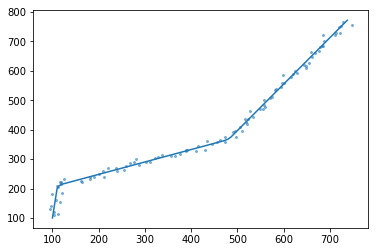

In [20]:
# longitudinal view

plt.plot(p[:,0],p[:,1])
plt.scatter(p_wiggle[:,0],p_wiggle[:,1], s=4, alpha=.5)
plt.show()

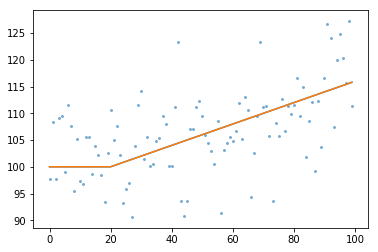

In [22]:
# vertical profile

plt.plot(p[:,2])
plt.scatter(np.arange(p_wiggle.shape[0]),p_wiggle[:,2], s=4, alpha=.5)
plt.show()

### Smooth with various values of $\lambda_1$ and $\lambda_2$

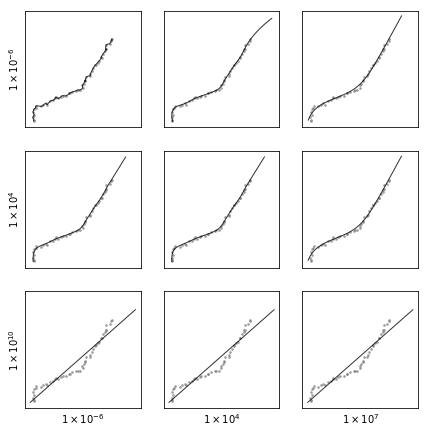

In [9]:
N = Ts+20
a = np.zeros(N)
a[:-20:2] = 1
Phat = np.zeros((N, 3))
Phat[:-20:2, :] = p_wiggle[::2, :]

lambda_1s = (1e-6,1e4,1e10)
lambda_2s = (1e-6,1e4,1e7)

fig, axs = plt.subplots(nrows=len(lambda_1s), ncols=len(lambda_2s), sharex=True, sharey=True)
fig.subplots_adjust(left=.08, bottom=.05, right=.99, top=.97)
for i, lambda_1 in enumerate(lambda_1s):
    for j, lambda_2 in enumerate(lambda_2s): 
        P = smooth(a, Phat, N, lambda_1, lambda_2)
        axs[i, j].scatter(p_wiggle[::2, 0], p_wiggle[::2, 1], s=3, alpha=.6, c='gray')
        axs[i, j].plot(P[:, 0], P[:, 1], linewidth=1, c='black', alpha=.8)
        axs[i, j].xaxis.set_major_formatter(plt.NullFormatter())
        axs[i, j].yaxis.set_major_formatter(plt.NullFormatter())
        axs[i,j].set_yticks([])
        axs[i,j].set_xticks([])
z = 40
axs[0, 0].set_ylabel('$1 \\times 10^{-6}$')
axs[1, 0].set_ylabel('$1 \\times 10^{4}$')
axs[2, 0].set_ylabel('$1 \\times 10^{10}$')
axs[-1, 0].set_xlabel('$1 \\times 10^{-6}$')
axs[-1, 1].set_xlabel('$1 \\times 10^{4}$')
axs[-1, 2].set_xlabel('$1 \\times 10^{7}$')
fig.set_size_inches(6, 6)
plt.show()

### Test out-of-sample-validation

In [14]:
def train_test_split(data, fraction_val):
    data_shuffled = shuffle(data)
    n_val = int(data.shape[0]*fraction_val)

    return data_shuffled[n_val:], data_shuffled[:n_val]

def convert_dataset(data, L):
    Phat = np.zeros((L, 3))
    a = np.zeros(L)
    for i in range(data.shape[0]):
        t, p = int(data[i, 0]), data[i, 1:]
        if t < L:
            Phat[t, :] += p
            a[t] += 1

    return Phat, a
def val_loss(a, P, Phat):
    return np.linalg.norm(np.diag(a).dot(P-Phat), 2)

def smooth_cross_validation(traj, fraction_val=.4, L=225):
    N = max(L, int(np.max(traj[:, 0])))

    best_loss, best_lambda_1, best_lambda_2 = float("inf"), 1., 1.
    train, test = train_test_split(traj, fraction_val)
    Phat_train, a_train = convert_dataset(train, N)
    Phat_test, a_test = convert_dataset(test, N)
    for log_lambda_1 in [-6, 4, 10]:
        for log_lambda_2 in [-6, 4, 10]:
            loss = 0.0
            P = smooth(a_train, Phat_train, N, 10**log_lambda_1, 10**log_lambda_2)
            loss = val_loss(a_test, P, Phat_test) / 50.
            if loss < best_loss:
                best_loss = loss
                best_lambda_1, best_lambda_2 = 10**log_lambda_1, 10**log_lambda_2
            print ("\\num{%.3f} & " % loss, end="")
        print ("\\\\")
    print ("best:", best_lambda_1, best_lambda_2)
    Phat, a = convert_dataset(traj, N)
    return smooth(a, Phat, N, best_lambda_1, best_lambda_2)

In [15]:
traj = np.c_[np.arange(p_wiggle.shape[0])*2, p_wiggle]
smooth_cross_validation(traj, L=int(np.max(traj[0, :])+1))
pass

\num{1.675} & \num{1.198} & \num{2.724} & \\
\num{1.138} & \num{1.143} & \num{2.724} & \\
\num{4.999} & \num{4.999} & \num{4.999} & \\
best: 10000 1e-06
